In [ ]:
import numpy as np
import pandas as pd
import zipfile
import os
import kagglehub
import time
from matplotlib import pyplot as plt
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV, HalvingRandomSearchCV
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
from xgboost import XGBClassifier
from scipy.stats import uniform, expon, loguniform

**Data Downloading and Cleaning**

In [ ]:
def process_data(train_data_path, test_data_path):
    """Download, process, and save US Accidents dataset as pandas dataframes.
    Plots are also produced and saved of the distribution of accidents over time.
    The data is split into a train and a test dataframe and is saved according to
    the given file paths.

    Parameter:
        train_data_path (str): Path the train data will be saved to.
        test_data_path (str): Path the test data will be saved to.
    """
    # Download latest version
    path = kagglehub.dataset_download("sobhanmoosavi/us-accidents")
    print("Path to dataset files:", path)
    # Extract the zip file if it exists
    zip_file_path = os.path.join(path, "US_Accidents_March23.csv.zip")
    if os.path.exists(zip_file_path):
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(path)  # Extract to the same directory
        print("Zip file extracted successfully.")

    # Find the CSV file inside the extracted directory
    csv_file_name = "US_Accidents_March23.csv"
    csv_file_path = os.path.join(path, csv_file_name)

    # Read the data broken into chunks (to avoid exceeding memory limits)
    reduced_data = []
    with pd.read_csv(csv_file_path, chunksize=int(2*10**6)) as reader:
        for chunk in reader:
            # Drop the following columns
            columns_to_drop = ['ID', 'Source', 'Airport_Code', 'Weather_Timestamp', 'Wind_Direction', 'Street',
                              'City','County', "State", 'Zipcode','Country','End_Lat', 'End_Lng', 'Description', 'Civil_Twilight',
                              'Nautical_Twilight', 'Astronomical_Twilight', 'Wind_Chill(F)', 'Timezone']
            chunk.drop(columns=columns_to_drop, inplace=True)
            reduced_data.append(chunk)
    # Concatentate the remaining data into a dataframe
    data = pd.concat(reduced_data, ignore_index=True)

    # Fill in missing Precipitation and Wind speed (corresponding to no preciptiation or wind speed)
    data['Precipitation(in)'] = data['Precipitation(in)'].fillna(0)
    data['Wind_Speed(mph)'] = data['Wind_Speed(mph)'].fillna(0)

    # Drop remaining rows with missing values
    data.dropna(inplace=True)

    # Get datetime data
    data['Start_Time'] = pd.to_datetime(data['Start_Time'], format='mixed')
    data['End_Time'] = pd.to_datetime(data['End_Time'], format='mixed')
    plot_data_time_data(data)

    # Replace End_Time with Elapsed_Time
    data['Elapsed_Time'] = data['End_Time'] - data['Start_Time']
    data.drop(columns='End_Time', inplace=True)

    # Scale data
    scaler = StandardScaler()
    data['Start_Time'] = (data['Start_Time'] - data['Start_Time'].min()) / np.timedelta64(1,'D')
    data['Elapsed_Time'] = data['Elapsed_Time'] / np.timedelta64(1,'D')
    data[[
        'Start_Time', 'Elapsed_Time', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)',
        'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)'
    ]] = scaler.fit_transform(data[[
        'Start_Time', 'Elapsed_Time', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)',
        'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)'
    ]])

    # Change sunrise_sunset to boolean
    data['Night'] = data['Sunrise_Sunset'] == 'Night'
    data.drop(columns='Sunrise_Sunset', inplace=True)

    # One-hot encode weather
    data = pd.get_dummies(data, columns=['Weather_Condition'])

    # Drop boolean variables with less than 10_000 instances
    data = data.drop(columns = [column for column in data.columns[data.dtypes == 'bool']
                                if data[column].sum() < 10000])

    # Add Constant columns
    data['Constant'] = 1

    # Check the new balanced counts
    print("Severity Counts")
    print(data['Severity'].value_counts())

    # Downsample each severity category to match the minimum count
    min_count = 193111
    data_severity_1 = data[data['Severity'] == 1]
    data_severity_2 = data[data['Severity'] == 2].sample(min_count, random_state=42)
    data_severity_3 = data[data['Severity'] == 3].sample(min_count, random_state=42)
    data_severity_4 = data[data['Severity'] == 4].sample(min_count, random_state=42)

    # Get train_data splits
    data_train_1, data_test_1 = train_test_split(data_severity_1, test_size=0.2, random_state=42)
    data_train_2, data_test_2 = train_test_split(data_severity_2, test_size=0.2, random_state=42)
    data_train_3, data_test_3 = train_test_split(data_severity_3, test_size=0.2, random_state=42)
    data_train_4, data_test_4 = train_test_split(data_severity_4, test_size=0.2, random_state=42)

    data_train = pd.concat([data_train_1, data_train_2, data_train_3, data_train_4])
    data_test = pd.concat([data_test_1, data_test_2, data_test_3, data_test_4])

    # Save data
    data_train.to_csv(train_data_path, index=False)
    data_test.to_csv(test_data_path, index=False)


def plot_data_time_data(data):
    """Plot the start time of accidents in a histogram. Two plots are generated,
    with one being the separated by severity level. The plots are then saved.

    Parameter:
        data (pandas.DataFrame): The dataframe containing the unscaled US Accident data
    """
    # Plot all start times with a histogram
    fig, ax = plt.subplots()
    times = data['Start_Time'].astype(np.int64)
    xticks = np.linspace(times.min(), times.max(), 10)
    times.plot.hist(ax=ax, bins=80, xticks=np.linspace(times.min(), times.max(), 8))
    labels = ax.get_xticks().tolist()
    labels = pd.to_datetime(labels).strftime('%-m/%-y')
    ax.set_xticklabels(labels, rotation=90)
    plt.savefig("start_times.png")

    # Plot start times separated by severity levels
    fig, ax = plt.subplots(2, 2, figsize=(10,6))
    times[data['Severity']==1].plot.hist(ax=ax[0][0], bins=80, xticks=np.linspace(times.min(), times.max(), 8), color='blue')
    labels = ax[0][0].get_xticks().tolist()
    labels = pd.to_datetime(labels).strftime('%-m/%-y')
    ax[0][0].set_xticklabels(labels, rotation=90)
    ax[0][0].set_title("Severity 1")

    times[data['Severity']==2].plot.hist(ax=ax[0][1], bins=80, xticks=np.linspace(times.min(), times.max(), 8), color='yellow')
    labels = ax[0][1].get_xticks().tolist()
    labels = pd.to_datetime(labels).strftime('%-m/%-y')
    ax[0][1].set_xticklabels(labels, rotation=90)
    ax[0][1].set_title("Severity 2")

    times[data['Severity']==3].plot.hist(ax=ax[1][0], bins=80, xticks=np.linspace(times.min(), times.max(), 8), color='orange')
    labels = ax[1][0].get_xticks().tolist()
    labels = pd.to_datetime(labels).strftime('%-m/%-y')
    ax[1][0].set_xticklabels(labels, rotation=90)
    ax[1][0].set_title("Severity 3")

    times[data['Severity']==4].plot.hist(ax=ax[1][1], bins=80, xticks=np.linspace(times.min(), times.max(), 8), color='red')
    labels = ax[1][1].get_xticks().tolist()
    labels = pd.to_datetime(labels).strftime('%-m/%-y')
    ax[1][1].set_xticklabels(labels, rotation=90)
    ax[1][1].set_title("Severity 4")
    plt.tight_layout()
    plt.savefig("severity_start_times.png")

100%|██████████| 653M/653M [00:08<00:00, 79.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sobhanmoosavi/us-accidents/versions/13
Severity Counts
Severity
2    5954624
3    1258535
4     193111
1      65678
Name: count, dtype: int64


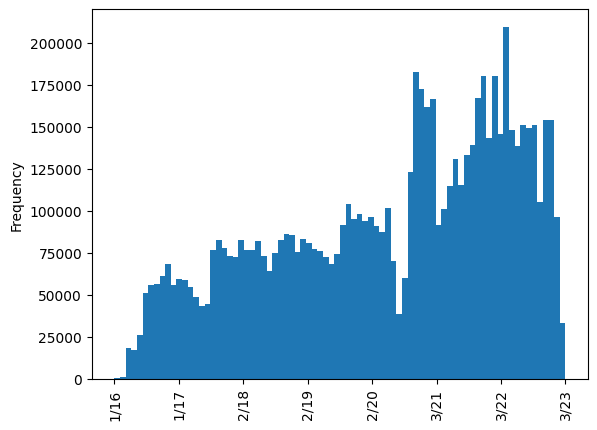

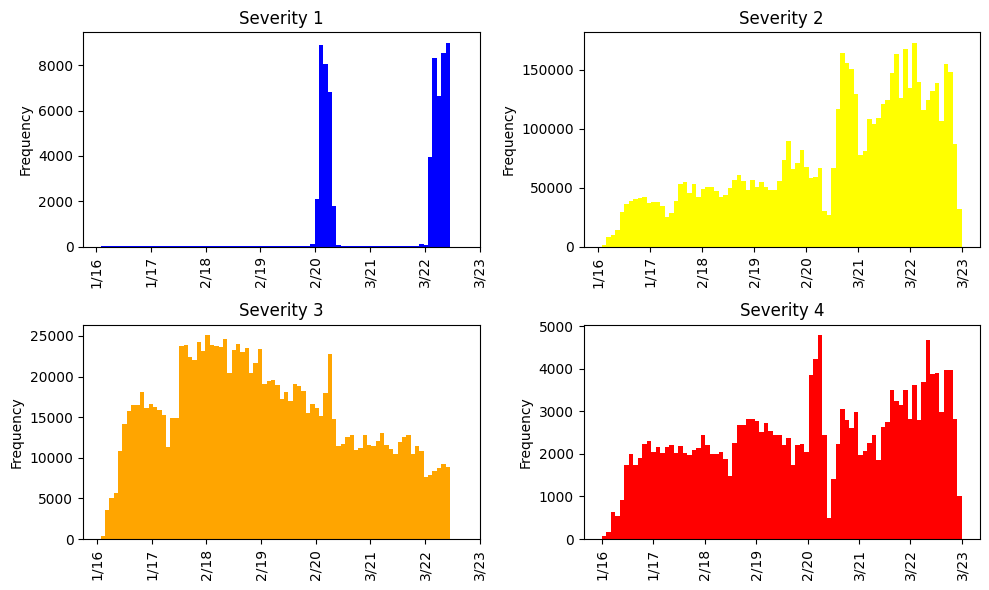

In [ ]:
# Download and process data
process_data("processed_train_data.csv", "processed_test_data.csv")

**Finetune Hyperparameters**

In [ ]:
def finetune_multinomial_regression(X_train, y_train):
    """Search and find optimal hyperparameters for multinomial logistic regression

      Parameters:
          X_train (pandas.DataFrame) -- The training data
          y_train (pandas.DataFrame) -- The training data labels
    """
    # Search over hyperparameters
    model = LogisticRegression(multi_class="multinomial", max_iter=1000, penalty='elasticnet', solver='saga')
    param_distributions = {'C': loguniform(1e-6, 1e6),
                          'l1_ratio': uniform(0, 1)}
    search = HalvingRandomSearchCV(model, param_distributions, n_candidates=100, resource='n_samples', min_resources=100, refit=False, n_jobs=-1).fit(X_train, y_train)

    # Print optimal hyperparameters
    print("Multinomial Hyperparamters")
    print(search.best_params_)

def finetune_svm(X_train, y_train):
    """Search and find optimal hyperparameters for support vector machines

      Parameters:
          X_train (pandas.DataFrame) -- The training data
          y_train (pandas.DataFrame) -- The training data labels
    """
    # Search over hyperparameters
    model = SVC(max_iter=1000)
    param_distributions = {'C': loguniform(1e-6, 1e6),
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                          'degree': [2, 3, 4, 5, 6]}
    search = HalvingRandomSearchCV(model, param_distributions, n_candidates=100, resource='n_samples', min_resources=100, refit=False, n_jobs=-1).fit(X_train, y_train)

    # Print optimal hyperparameters
    print("SVM Hyperparamters")
    print(search.best_params_)

def finetune_random_forest(X_train, y_train):
    """Search and find optimal hyperparameters for a random forest classifier

      Parameters:
          X_train (pandas.DataFrame) -- The training data
          y_train (pandas.DataFrame) -- The training data labels
    """
    # Subsample data
    X_sample, _, y_sample, _ = train_test_split(X_train, y_train, train_size=20000)

    # Search over hyperparameters
    model = RandomForestClassifier()
    param_distributions = {'max_depth': [30, 50, 80],
                          'min_samples_leaf': [1e-2, 1e-3, 1e-4],
                          'max_features': [20, 50, None]}
    search = HalvingGridSearchCV(model, param_distributions, resource='n_estimators', min_resources=10, max_resources=200, refit=False).fit(X_sample, y_sample)

    # Print optimal hyperparameters
    print("Random Forest Hyperparamters")
    print(search.best_params_)

def finetune_xgboost(X_train, y_train):
    """Search and find optimal hyperparameters for XGBoost

      Parameters:
          X_train (pandas.DataFrame) -- The training data
          y_train (pandas.DataFrame) -- The training data labels
    """
    # Search over hyperparameters
    model = XGBClassifier()
    param_distributions = {'learning_rate': uniform(),
                          'max_depth': [3, 6, 10, 20],
                          'reg_alpha': expon(),
                          'reg_lambda': expon(),
                          'min_split_loss': expon()}

    search = HalvingRandomSearchCV(model, param_distributions, n_candidates=1000, resource='n_samples', min_resources=100, refit=False, n_jobs=-1).fit(X_train, y_train-1)

    # Print optimal hyperparameters
    print("XGBoost Hyperparamters")
    print(search.best_params_)

def finetune_knn(X_train, y_train):
    """Search and find optimal hyperparameters for k-neighbors classifiers

      Parameters:
          X_train (pandas.DataFrame) -- The training data
          y_train (pandas.DataFrame) -- The training data labels
    """
    # Search over hyperparameters
    model = KNeighborsClassifier()
    param_distributions = {'n_neighbors': [2, 3, 5, 8, 10, 20],
                          'weights': ['uniform', 'distance'],
                          'leaf_size': [20, 30, 50, 100],
                          'p': [1, 2]}
    search = HalvingRandomSearchCV(model, param_distributions, n_candidates=100, resource='n_samples', min_resources=200, refit=False, n_jobs=-1).fit(X_train, y_train)

    # Print optimal hyperparameters
    print("KNN Hyperparamters")
    print(search.best_params_)

In [ ]:
# Load Data
train_data = pd.read_csv("processed_train_data.csv")
test_data = pd.read_csv("processed_test_data.csv")
print("Traning Data Length:", len(train_data))
print("Test Data Length:", len(test_data))

# Separate into X and y
X_train = train_data.drop(columns=["Severity"])
y_train = train_data["Severity"]
X_test = test_data.drop(columns=["Severity"])
y_test = test_data["Severity"]

# Finetune (results may vary)
finetune_multinomial_regression(X_train, y_train)
finetune_svm(X_train, y_train)
finetune_random_forest(X_train, y_train)
finetune_xgboost(X_train, y_train)
finetune_knn(X_train, y_train)

Traning Data Length: 516006
Test Data Length: 129005
Multinomial Hyperparamters
{'C': 3.9953441690477294, 'l1_ratio': 0.9660664977475012}
SVM Hyperparamters
{'C': 3.9983620052757862, 'degree': 2, 'kernel': 'rbf'}


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Random Forest Hyperparamters
{'max_depth': 50, 'max_features': 50, 'min_samples_leaf': 0.0001, 'n_estimators': 90}
XGBoost Hyperparamters
{'learning_rate': 0.07035103983518898, 'max_depth': 20, 'min_split_loss': 0.8783308514538826, 'reg_alpha': 2.8122987492950253, 'reg_lambda': 0.788977275906785}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 96 is smaller than n_iter=100. Running 96 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


KNN Hyperparamters
{'weights': 'distance', 'p': 2, 'n_neighbors': 20, 'leaf_size': 50}


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


**Model Training**

In [ ]:
def roc_curve_plotter(model, y_test, X_test):
    """Generate a ROC Curve of a given model on test data.

    Parameters:
        model (sklearn.base.ClassifierMixin) -- A model with the predict_proba method
        y_test (pandas.DataFrame) -- The test data labels
        X_test (pandas.DataFrame) -- The test data
    """
    y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4])

    # Set up the subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Create a ROC curve for each class (one-vs-rest)
    colors = ["blue", "yellow", "orange", "red"]
    for i, ax in enumerate(axes.ravel()):
        y_score = model.predict_proba(X_test)[:, i]  # Get probability predictions for class i
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score)  # Calculate FPR and TPR
        RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc(fpr, tpr), estimator_name=f"Severity {i+1} vs Rest").plot(ax=ax, c=colors[i])
        ax.set_title(f"ROC Curve for Severity {i+1} vs Rest")

    plt.tight_layout()
    plt.show()

In [ ]:
def multinomial_regression(X_train, y_train, X_test, y_test):
    """Trains multinomial logistic regression on our data and prints the results

    Parameters:
        X_train (pandas.DataFrame) -- The training data
        y_train (pandas.DataFrame) -- The training data labels
        X_test (pandas.DataFrame) -- The test data
        y_test (pandas.DataFrame) -- The test data labels
    """
    # Subsample training data to fit
    X_sample, _, y_sample, _ = train_test_split(X_train, y_train, train_size=10000)

    # Initialize model
    model = LogisticRegression(multi_class="multinomial", max_iter=10000, C = 1.4451967305615503, penalty='l1', n_jobs=-1, solver='saga')

    # Fit model
    start = time.time()
    model.fit(X_sample, y_sample)
    end = time.time()

    # Get and print results
    print("Multinomial Regression")
    print("Train Score:",model.score(X_train, y_train))
    print("Test Score:",model.score(X_test, y_test))
    print(f"Time: {end-start}")
    roc_curve_plotter(model, y_test, X_test)

def svm(X_train, y_train, X_test, y_test):
    """Trains a support vector machine on our data and prints the results

    Parameters:
        X_train (pandas.DataFrame) -- The training data
        y_train (pandas.DataFrame) -- The training data labels
        X_test (pandas.DataFrame) -- The test data
        y_test (pandas.DataFrame) -- The test data labels
    """
    # Subsample training data to fit
    X_sample, _, y_sample, _ = train_test_split(X_train, y_train, train_size=10000)

    # Initialize model
    model = SVC(max_iter=10000, C=0.22188594953554158, kernel='linear', probability=True)

    # Fit model
    start = time.time()
    model.fit(X_sample, y_sample)
    end = time.time()

    # Get and print results
    print("Support Vector Machine")
    print("Train Score:",model.score(X_train, y_train))
    print("Test Score:",model.score(X_test, y_test))
    print(f"Time: {end-start}")
    roc_curve_plotter(model, y_test, X_test)


def random_forest(X_train, y_train, X_test, y_test, columns):
    """Trains a random forest on our data, extracts the most important features, and prints the results

    Parameters:
        X_train (pandas.DataFrame) -- The training data
        y_train (pandas.DataFrame) -- The training data labels
        X_test (pandas.DataFrame) -- The test data
        y_test (pandas.DataFrame) -- The test data labels
        columns (list) -- The names of the columns in the data
    """
    # Initialize model
    model = RandomForestClassifier(n_estimators=400, max_depth=50, min_samples_leaf=0.0001, max_features=50, max_samples=100000, n_jobs=-1)

    # Fit model
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()

    # Get and print results
    ordered_features = list(sorted(list(zip(model.feature_importances_, columns))))
    print("Random Forest")
    print(f"3 least important features: {ordered_features[0][1]}, {ordered_features[1][1]}, {ordered_features[2][1]}")
    print(f"3 most important features: {ordered_features[-1][1]}, {ordered_features[-2][1]}, {ordered_features[-3][1]}")
    print(f"Train Score: {model.score(X_train,y_train)}")
    print(f"Test Score: {model.score(X_test,y_test)}")
    print(f"Time: {end-start}")
    roc_curve_plotter(model, y_test, X_test)


def xg_boost(X_train, y_train, X_test, y_test, columns):
    """Trains XGBoost on our data, extracts the most important features, and prints the results

    Parameters:
        X_train (pandas.DataFrame) -- The training data
        y_train (pandas.DataFrame) -- The training data labels
        X_test (pandas.DataFrame) -- The test data
        y_test (pandas.DataFrame) -- The test data labels
        columns (list) -- The names of the columns in the data
    """
    # Initialize model
    model = XGBClassifier(objective="multi:softmax", reg_alpha=1.838880935749238, min_split_loss=1.1615840861586064, reg_lambda=0.1924921545157662,learning_rate=0.112104412284738, max_depth=20)

    # Fit model
    start = time.time()
    model.fit(X_train, y_train-1)
    end = time.time()

    # Get and print results
    ordered_guy = list(sorted(list(zip(model.feature_importances_, columns))))
    print("XGBoost")
    print(f"3 least important features: {ordered_guy[0][1]}, {ordered_guy[1][1]}, {ordered_guy[2][1]}")
    print(f"3 most important features: {ordered_guy[-1][1]}, {ordered_guy[-2][1]}, {ordered_guy[-3][1]}")
    print(f"Train Score: {model.score(X_train,y_train-1)}")
    print(f"Test Score: {model.score(X_test,y_test-1)}")
    print(f"Time: {end-start}")
    roc_curve_plotter(model, y_test, X_test)

def kneighbors(X_train, y_train, X_test, y_test):
    """Trains a k neighbors classifier on our data and prints the results

    Parameters:
        X_train (pandas.DataFrame) -- The training data
        y_train (pandas.DataFrame) -- The training data labels
        X_test (pandas.DataFrame) -- The test data
        y_test (pandas.DataFrame) -- The test data labels
    """
    # Subsample training data to fit
    X_sample, _, y_sample, _ = train_test_split(X_train, y_train, train_size=10000)

    # Initialize model
    model = KNeighborsClassifier(weights='uniform', p=1, n_neighbors=10, leaf_size=20, n_jobs=-1)

    # Fit model
    start = time.time()
    model.fit(X_sample, y_sample)
    end = time.time()

    # Get and print results
    print("KNN")
    print("Train Score:",model.score(X_train, y_train))
    print("Test Score:",model.score(X_test, y_test))
    print(f"Time: {end-start}")
    roc_curve_plotter(model, y_test, X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Multinomial Regression
Train Score: 0.529895001220916
Test Score: 0.5325762567342351
Time: 178.00298261642456


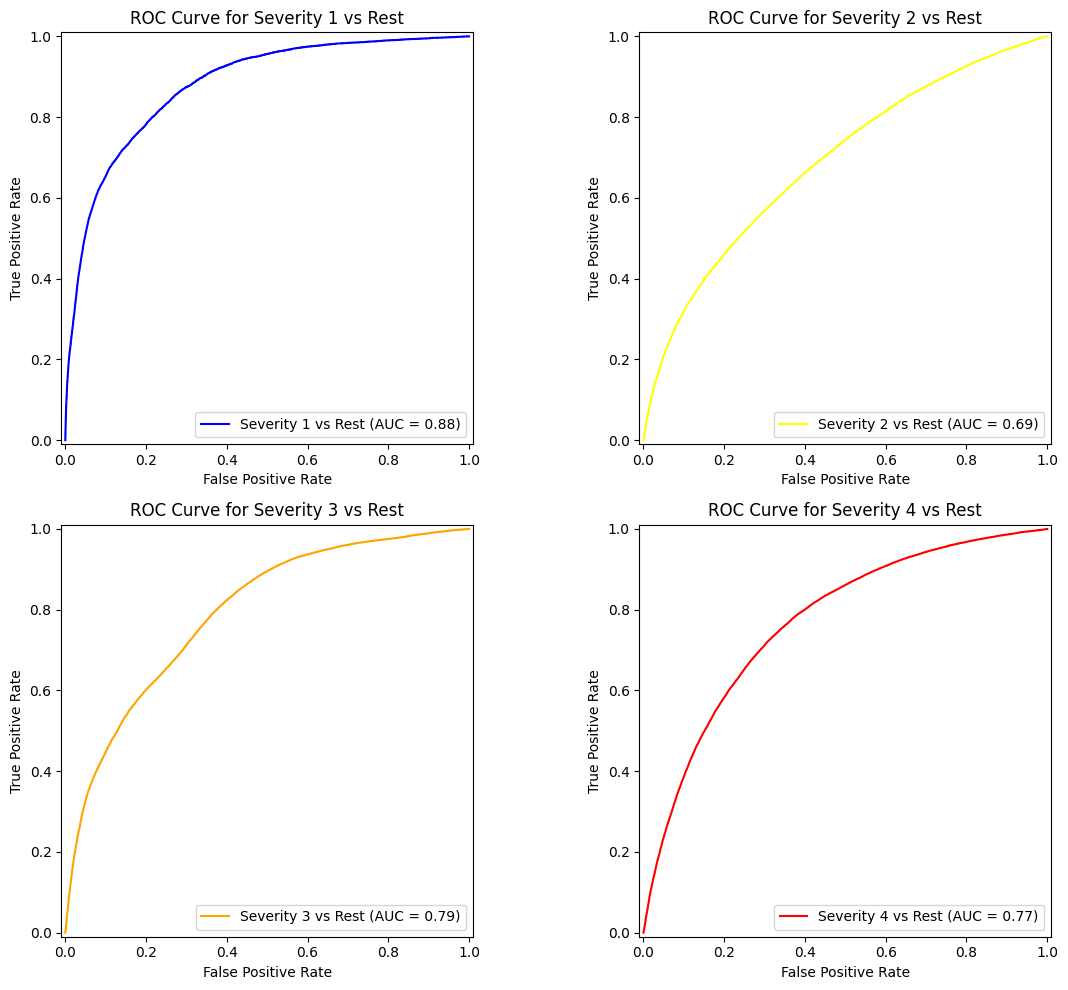

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Support Vector Machine
Train Score: 0.5259318690092751
Test Score: 0.5281733266152475
Time: 48.424227714538574


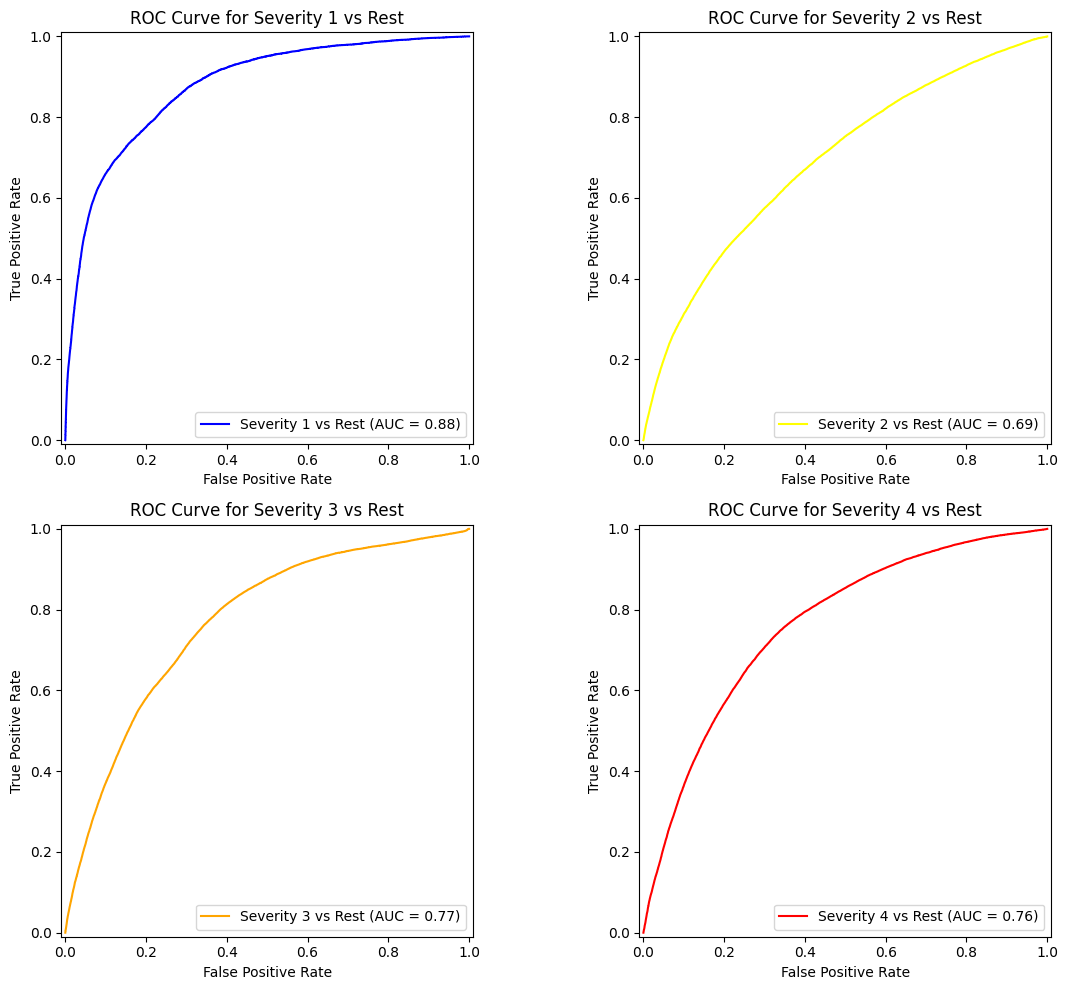

Random Forest
3 least important features: Constant, Give_Way, No_Exit
3 most important features: Distance(mi), Start_Time, Elapsed_Time
Train Score: 0.7731266690697395
Test Score: 0.7676136583853339
Time: 697.8059210777283


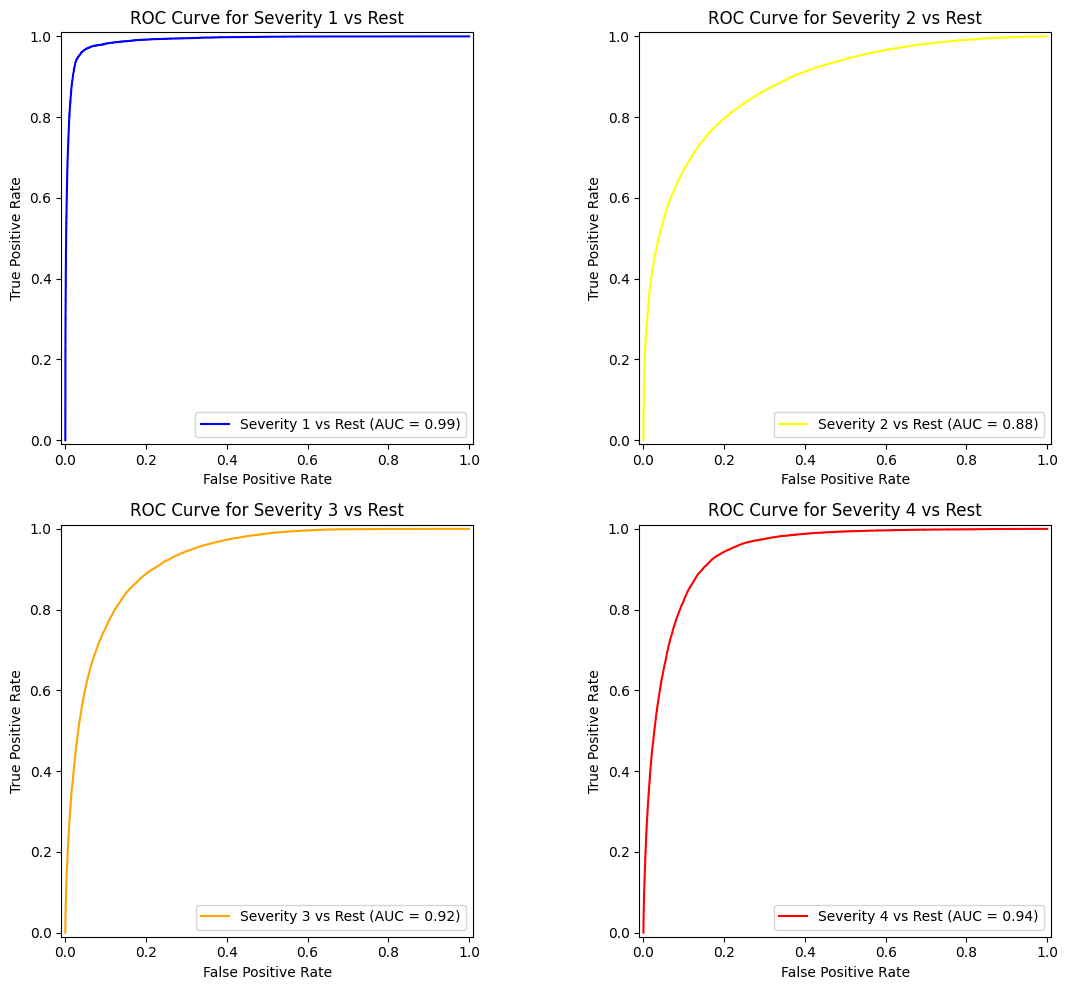

XGBoost
3 least important features: Constant, Weather_Condition_Partly Cloudy / Windy, Weather_Condition_Wintry Mix
3 most important features: Distance(mi), Traffic_Signal, Start_Time
Train Score: 0.8819548609899885
Test Score: 0.8169605829231426
Time: 95.11929130554199


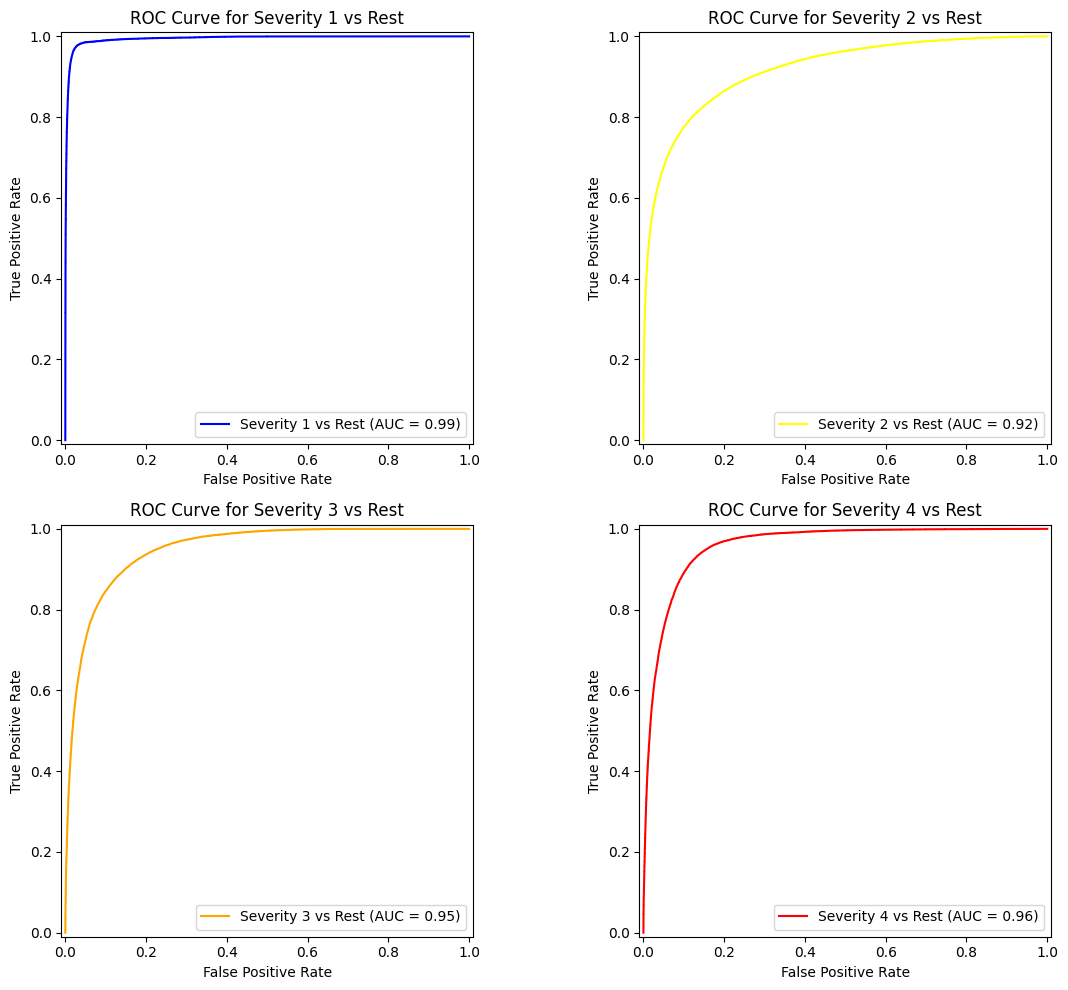

KNN
Train Score: 0.5182245942876633
Test Score: 0.5171660013177783
Time: 0.006440639495849609


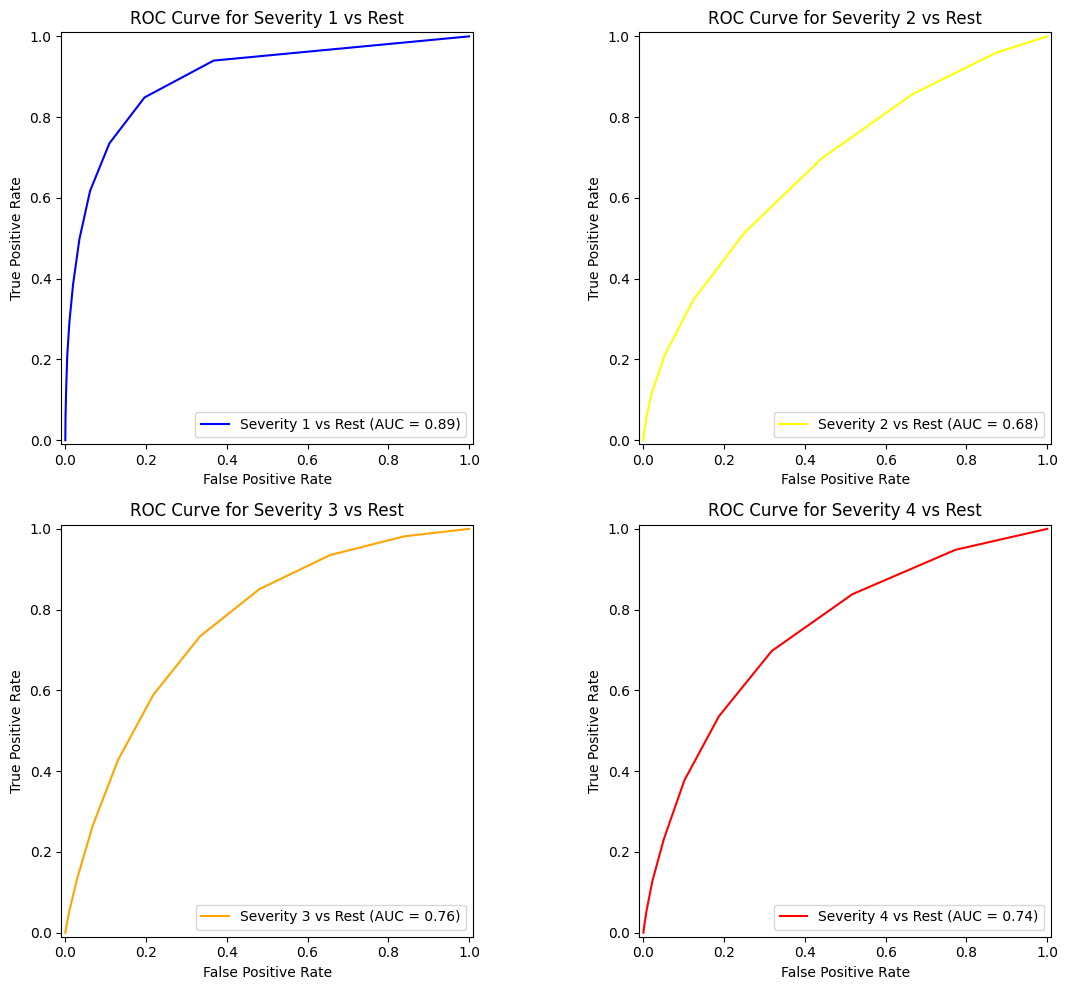

In [ ]:
# Train data
multinomial_regression(X_train, y_train, X_test, y_test)
svm(X_train, y_train, X_test, y_test)
random_forest(X_train, y_train, X_test, y_test, X_train.columns)
xg_boost(X_train, y_train, X_test, y_test, X_train.columns)
kneighbors(X_train, y_train, X_test, y_test)

**Data Analysis**

In [ ]:
def perform_pca(X,y):
    """Performs PCA on the data and plots it

    Args:
        X (np.array): Data frame without including severity
        y (_type_): Data frame only consisting of severity
    """
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Initialize PCA and fit to the data
    pca = PCA(n_components=3)  # Change n_components as needed
    X_pca = pca.fit_transform(X_scaled)

    # Get the eigenvectors
    eigenvectors = pca.components_

    # Print the first eigenvector and its correlations
    first_eigenvector = eigenvectors[0]
    print("First Principal Component Eigenvector (PC1):")
    print(first_eigenvector)

    # Print the features correlated with the first eigenvector
    correlations_pc1 = pd.Series(first_eigenvector, index=X.columns)
    print("\nCorrelations with PC1:")
    print(correlations_pc1)

    # Print the second eigenvector and its correlations
    second_eigenvector = eigenvectors[2]
    print("\nSecond Principal Component Eigenvector (PC2):")
    print(second_eigenvector)

    # Print the features correlated with the second eigenvector
    correlations_pc2 = pd.Series(second_eigenvector, index=X.columns)
    print("\nCorrelations with PC2:")
    print(correlations_pc2)

    # Create a scatter plot, colored by y
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y, alpha = .5)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')

    ax = fig.add_subplot(122,projection='3d')
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:,2], c=y, alpha = .5)
    plt.colorbar(scatter, label='Classes')
    plt.suptitle('PCA of Traffic Data')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    ax.set_zlabel("Principle Component 3")
    plt.grid(True)
    plt.tight_layout()

    plt.show()

In [ ]:
# Combine Data
total_data = pd.concat([train_data, test_data])

# Get correlation
corr = total_data.corr(method='spearman')["Severity"]

# Print sorted correlation values
sorted_corr = corr.sort_values(ascending=False)
print(sorted_corr)

Severity                                     1.000000
Distance(mi)                                 0.400045
Elapsed_Time                                 0.218158
Start_Lat                                    0.166440
Start_Lng                                    0.141951
Night                                        0.124628
Weather_Condition_Clear                      0.112260
Weather_Condition_Overcast                   0.085056
Pressure(in)                                 0.078648
Junction                                     0.066065
Humidity(%)                                  0.056413
Weather_Condition_Scattered Clouds           0.047490
Weather_Condition_Light Snow                 0.040591
Precipitation(in)                            0.017509
Weather_Condition_Snow                       0.017311
Weather_Condition_Light Rain                 0.014841
Weather_Condition_Smoke                      0.009927
Weather_Condition_Wintry Mix                 0.009206
Weather_Condition_Light Driz

First Principal Component Eigenvector (PC1):
[-1.17623827e-01  2.09439922e-01  9.76493732e-02  8.56454127e-02
 -3.95681585e-01  4.41055750e-01  7.71053023e-02 -3.93414032e-01
 -7.15835422e-02  9.62142912e-02 -5.60532575e-02 -1.98150297e-01
 -2.02886708e-02  6.59251893e-02 -3.24108684e-02 -5.32074652e-02
 -7.99752084e-02 -2.73377728e-02 -1.90321526e-01  2.50197250e-03
  2.18175831e-01  8.78442580e-03  9.82582374e-02  2.28131196e-03
 -2.71198448e-01 -4.04795132e-02  1.58634535e-01  3.90444194e-02
  7.88665397e-02  5.21274703e-02  1.56442471e-01  1.19562383e-02
  2.17681259e-01 -7.21194849e-02 -2.31797579e-02  1.53719912e-01
 -9.71531412e-02 -2.16647358e-02  1.14126287e-01 -1.91114523e-02
  2.37644703e-04  8.85346518e-02  2.61152775e-02 -1.66801628e-02
 -1.79549935e-02  5.36247628e-02  0.00000000e+00]

Correlations with PC1:
Start_Time                                  -0.117624
Start_Lat                                    0.209440
Start_Lng                                    0.097649
Dist

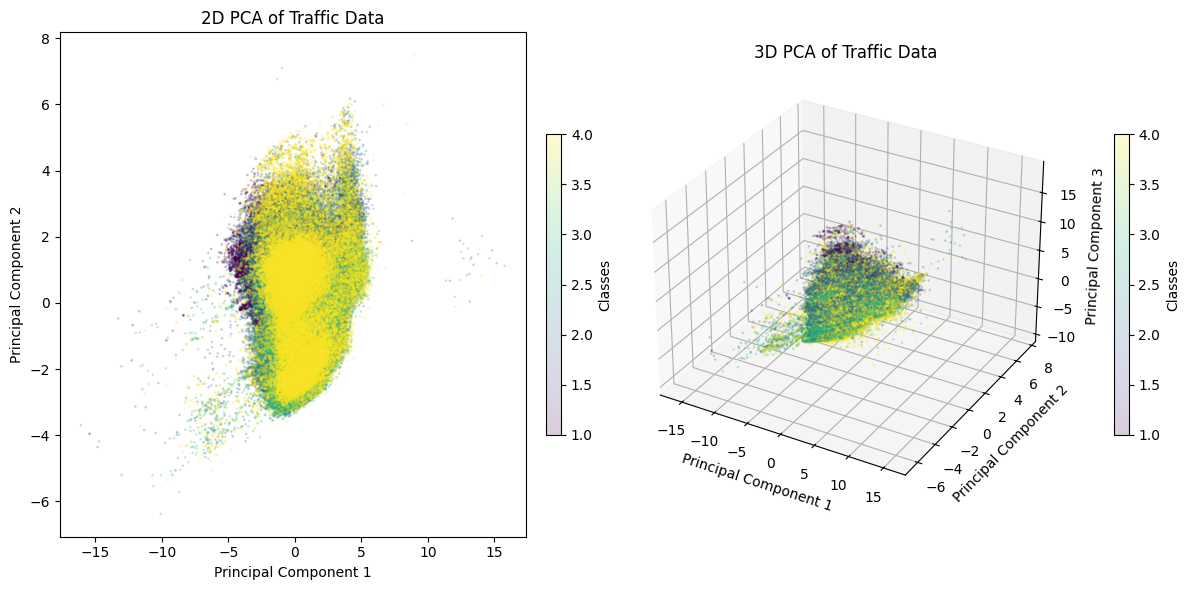

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

def perform_pca(X, y):
    """Performs PCA on the data and plots it

    Args:
        X (np.array): Data frame without including severity
        y (np.array): Data frame only consisting of severity
    """
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Initialize PCA and fit to the data
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X_scaled)

    # Get the eigenvectors
    eigenvectors = pca.components_

    # Print the first eigenvector and its correlations
    first_eigenvector = eigenvectors[0]
    print("First Principal Component Eigenvector (PC1):")
    print(first_eigenvector)

    # Print the features correlated with the first eigenvector
    correlations_pc1 = pd.Series(first_eigenvector, index=X.columns)
    print("\nCorrelations with PC1:")
    print(correlations_pc1)

    # Print the second eigenvector and its correlations
    second_eigenvector = eigenvectors[1]
    print("\nSecond Principal Component Eigenvector (PC2):")
    print(second_eigenvector)

    # Print the features correlated with the second eigenvector
    correlations_pc2 = pd.Series(second_eigenvector, index=X.columns)
    print("\nCorrelations with PC2:")
    print(correlations_pc2)

    # Create a scatter plot, colored by y
    fig = plt.figure(figsize=(12, 6))

    # 2D PCA scatter plot
    ax1 = fig.add_subplot(121)
    scatter = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=y, alpha=0.2, s=1, cmap='viridis')
    ax1.set_xlabel('Principal Component 1')
    ax1.set_ylabel('Principal Component 2')
    ax1.set_title('2D PCA of Traffic Data')
    fig.colorbar(scatter, ax=ax1, label='Classes', fraction=0.03, pad=0.04)

    # 3D PCA scatter plot
    ax2 = fig.add_subplot(122, projection='3d')
    scatter = ax2.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, alpha=0.2, s=1, cmap='viridis')
    fig.colorbar(scatter, ax=ax2, label='Classes', fraction=0.03, pad=0.1)
    ax2.set_xlabel('Principal Component 1')
    ax2.set_ylabel('Principal Component 2')
    ax2.set_zlabel('Principal Component 3')
    ax2.set_title('3D PCA of Traffic Data')

    plt.tight_layout()
    plt.show()

# Assuming data is a pandas DataFrame with columns for features and "Severity" as target variable
X = total_data.drop(columns=["Severity"])
y = total_data["Severity"]
perform_pca(X, y)
